# Conducting Between Analysis Between Region

Here we conduct physical analysis between basins.

1) We download a handful of floats into a parquet and estimate potential density and calculate MLD

2) Expansion into a larger dataset, Here we expand nº1 into a larger dataset and seperating into regions

In [13]:
# Libraries for data handling

import polars as pl
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Library for estimating oceanographic parameters
import gsw

# Library for donwloading data

import os
from pathlib import Path
import argopy
from argopy import DataFetcher

In [14]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
xr.set_options(display_expand_attrs = False)

import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

# Downloading Handful of floats

Downloading speific floats and estiamte physical parameters

## Downloading Floats 

In [27]:
# Base filepath
root = '../data/argo/'
profile_dir = root + 'Profiles/'

# Create GO-BGC folders if they do not exist yet
if 'argo' not in os.listdir('../data/'):
  os.mkdir(root)
if 'Profiles' not in os.listdir(root):
  os.mkdir(profile_dir)

# Downloading data using argopy
float_ids = [6903871, 6902882, 6902802, 6901627, 6902807, 6901601, 6901029]  # Ice Shelf and Open Ocean Floats

# Fetching data
ds = DataFetcher(src ='gdac', 
                 mode = 'standard').float(
                     float_ids).to_xarray()

# Quality Control Filtering
ds = ds.argo.filter_qc(QC_list=[1,2])  # Keep only good and probably good data

# Downloading data using argopy

ds = ds.to_dataframe().reset_index()
ds = pl.from_pandas(ds)

# Saving in one dataset parquet
out_path = Path(profile_dir)/ f"Grouped_data_set.parquet"
out_path.parent.mkdir(parents=True, exist_ok=True)

ds.write_parquet(out_path)
print(f"Saved all float in one parquet -> {profile_dir}")

# Saving by Float number
#for fid in float_ids:
#    sub = ds.filter(pl.col("PLATFORM_NUMBER") == fid)
#    out_path = Path(profile_dir)/ f"{fid}.parquet"
#    out_path.parent.mkdir(parents=True, exist_ok=True)
#    sub.write_parquet(out_path)
#    print(f"Saved float {fid} -> {profile_dir}")


Saved all float in one parquet -> ../data/argo/Profiles/


## Comparing Basins

Creating Function:

1) density Calcl
2) Sigma0 Potential density
3) Estimating Mixlayer depth using the density threshold of ~0.3

In [ ]:
# Defining Function

"""
  In site density Calculation Function.
Using Gibbs SeaWater (GSW) Oceanographic Toolbox, it is added as 
another column to the Polars DataFrame.
"""
def add_density(df: pl.DataFrame) -> pl.DataFrame:
    # Extract numpy arrays
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    # Compute absolute salinity, conservative temperature, density
    SA  = gsw.SA_from_SP(SP, p, lon, lat)
    CT  = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)

    # Append new column as a Polars Series
    return df.with_columns(pl.Series("RHO", rho))

# Creating potential density function (for MLD calculations)
def add_sigma0(df: pl.DataFrame) -> pl.DataFrame:
    """
    Add potential density anomaly sigma0 [kg/m^3 - 1000] as a column 'SIGMA0'.
    Requires PSAL [PSS-78], TEMP [°C in-situ], PRES [dbar], LONGITUDE [degE], LATITUDE [degN].
    """
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)  # kg/m^3 - 1000
    return df.with_columns(pl.Series("SIGMA0", sigma0))

# Creating Mixed Layer Depth function for MLD calculations
"""
 Calculation based on de Montety et al. (2014) definition:
"""
# Compute MLD per profile
def compute_mld_for_profile(pres: np.ndarray, sigma0: np.ndarray,
                            ref_depth: float = 10.0, drho_threshold: float = 0.03) -> float:
    sort_idx = np.argsort(pres)
    pres_sorted = pres[sort_idx]
    sigma0_sorted = sigma0[sort_idx]
    idx_ref = np.argmin(np.abs(pres_sorted - ref_depth))
    sigma0_ref = sigma0_sorted[idx_ref]
    sigma0_th = sigma0_ref + drho_threshold
    mask = sigma0_sorted >= sigma0_th
    mask[:(idx_ref+1)] = False
    if not np.any(mask):
        return np.nan
    idx_mld = np.where(mask)[0][0]
    return float(pres_sorted[idx_mld])





In [59]:
# Loading data 
df = pl.read_parquet('../data/argo/profiles/Grouped_data_set.parquet')

# Filtering data below 500m
df = df.filter(pl.col('PRES') < 500)

# Applying potential density Density calc Function
df = add_sigma0(df)

# Groupin and computing MLD per profile 
summary_mld = (
    df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER")
      .map_groups(lambda group: pl.DataFrame({
            "PLATFORM_NUMBER": [group["PLATFORM_NUMBER"].to_list()[0]],
            "CYCLE_NUMBER": [group["CYCLE_NUMBER"].to_list()[0]],
            "MLD": [
              compute_mld_for_profile(
                pres=group["PRES"].to_numpy(),
                sigma0=group["SIGMA0"].to_numpy(),
                ref_depth=10.0,
                drho_threshold=0.03
              )
            ]
        }))
)

# Joining MLD replicating to dataframe
df = df.join(summary_mld, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()




ColumnNotFoundError: "PSAL_ADJUSTED" not found

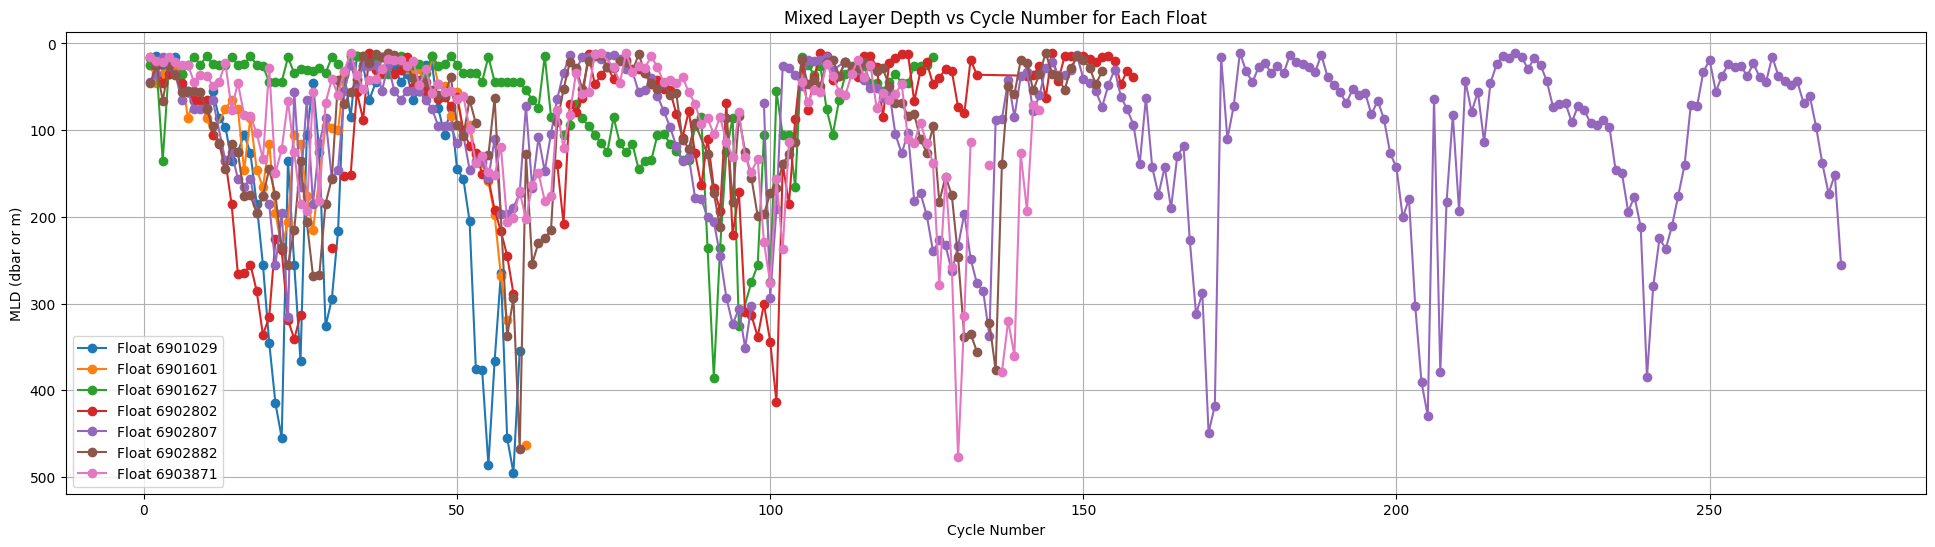

In [ ]:
# Plotting df

cycle_summary = (df.
                 select("PLATFORM_NUMBER", "CYCLE_NUMBER", "MLD")
                 .unique()
                 .sort("PLATFORM_NUMBER", "CYCLE_NUMBER"))

summary_pd = cycle_summary.to_pandas()


fig, ax = plt.subplots(figsize=(24,6))
for float_id, sub in summary_pd.groupby("PLATFORM_NUMBER"):
    ax.plot(sub["CYCLE_NUMBER"], sub["MLD"],
            marker="o", label=f"Float {float_id}")

ax.set_xlabel("Cycle Number")
ax.set_ylabel("MLD (dbar or m)")
ax.set_title("Mixed Layer Depth vs Cycle Number for Each Float")
ax.invert_yaxis()  # optional: deeper = larger depth, so invert if you want shallow at top
ax.legend()
plt.grid(True)
plt.show()

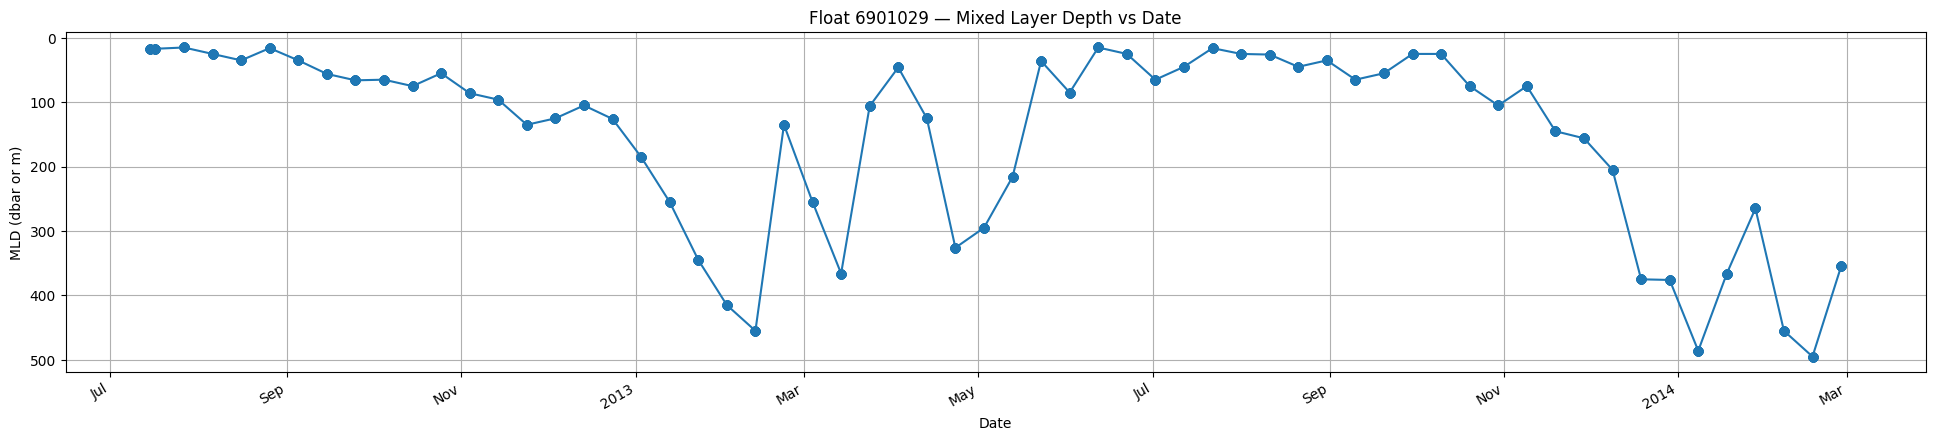

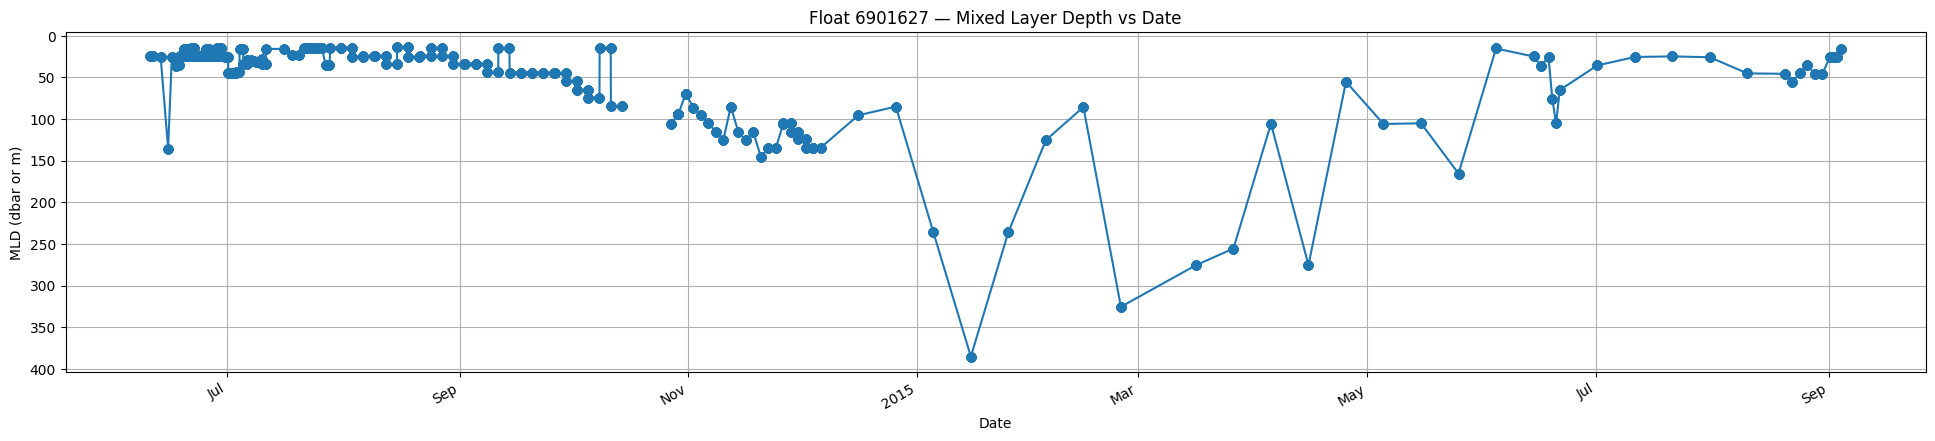

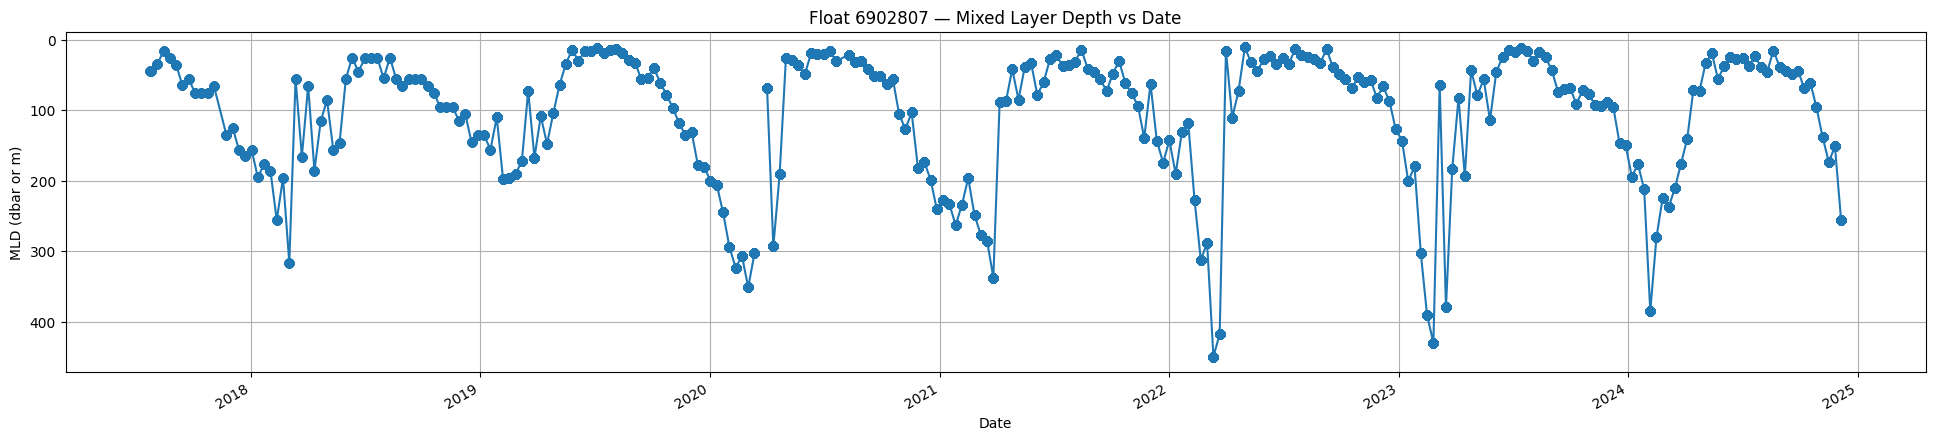

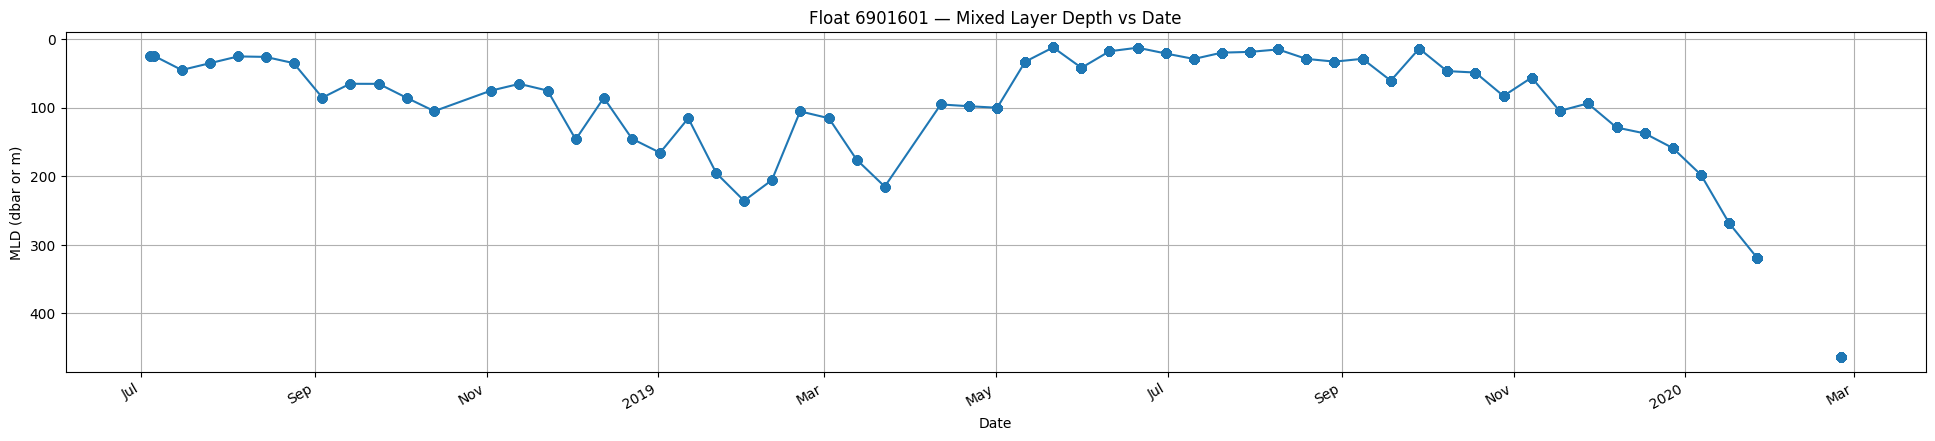

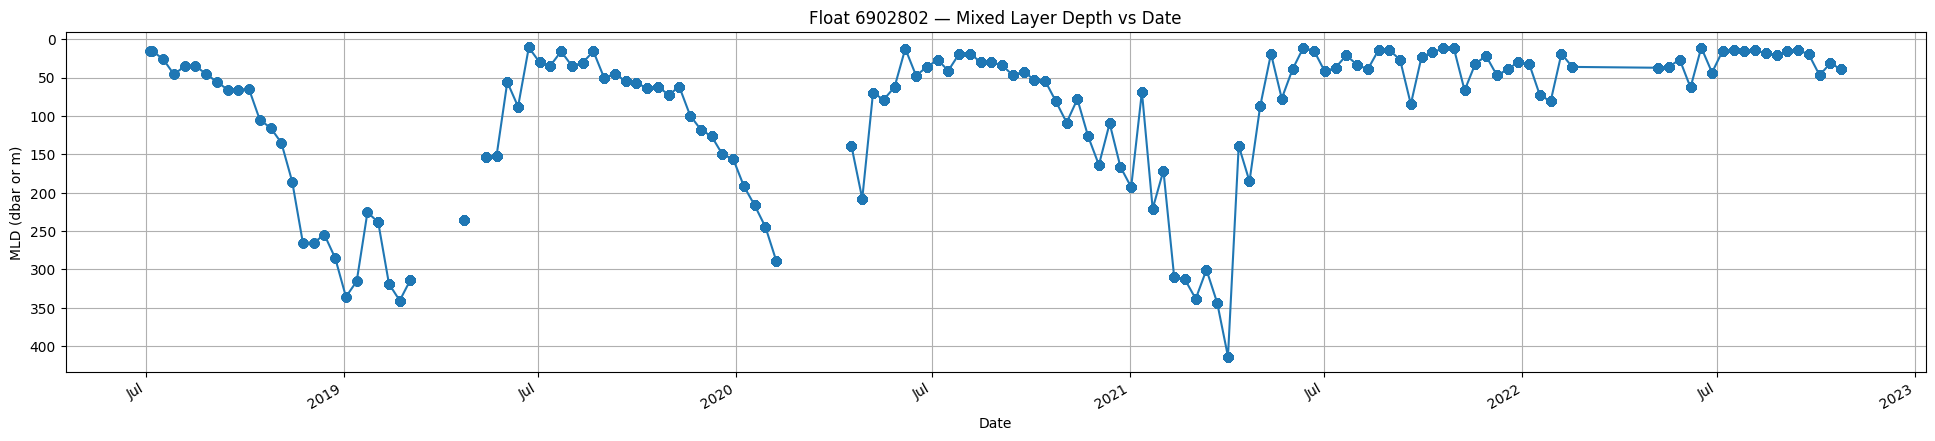

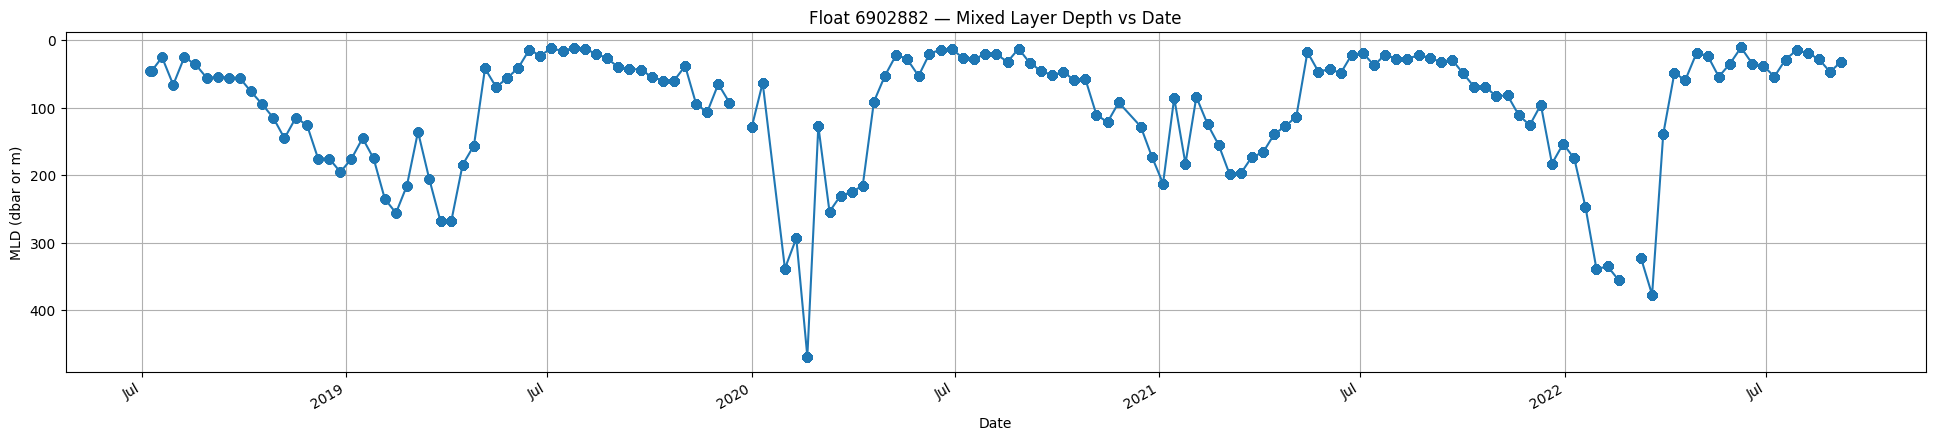

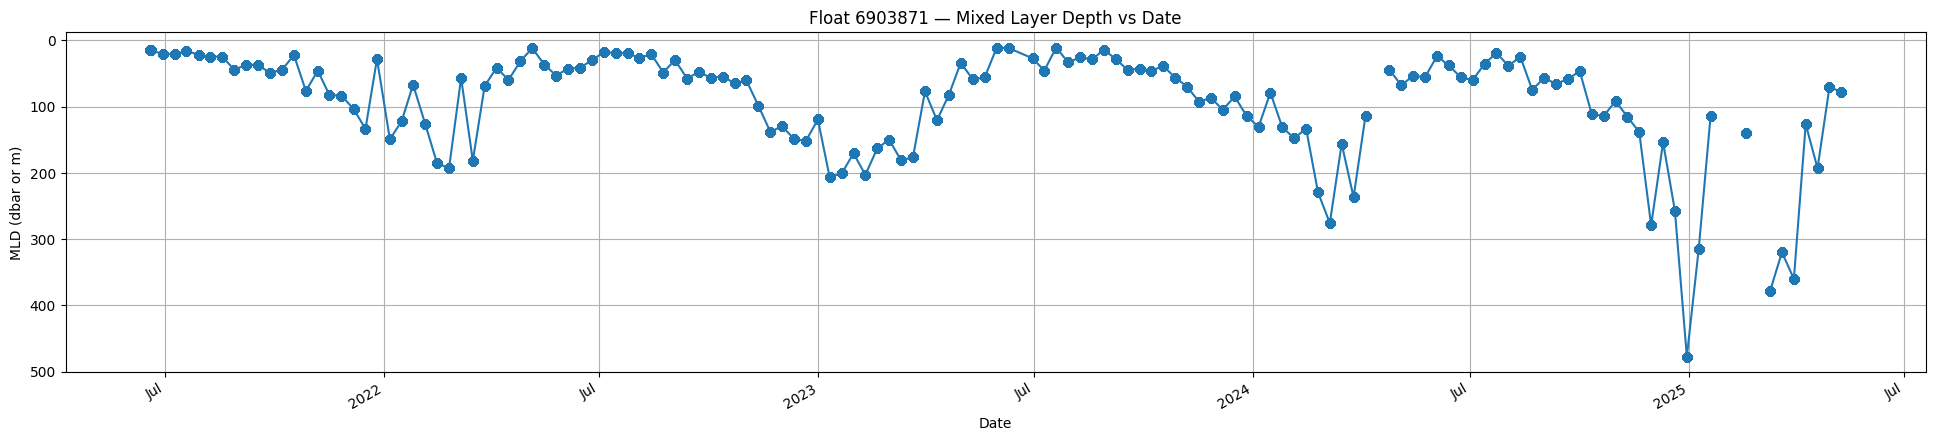

In [ ]:
pd_df = df.to_pandas()

# Make sure your date column is a proper datetime
# Example: if your column is 'JULD', convert like:
pd_df['TIME'] = pd.to_datetime(pd_df['TIME'])

# Filter by each float and plot
for fid in pd_df['PLATFORM_NUMBER'].unique():
    sub = pd_df[pd_df['PLATFORM_NUMBER'] == fid]
    # Summarise one MLD per cycle (assuming one MLD per cycle)
    summary = sub.groupby('CYCLE_NUMBER').agg({
        'TIME': 'first',   # or maybe 'min' or 'max' depending
        'MLD': 'first'
    }).reset_index()

    fig, ax = plt.subplots(figsize=(24,5))
    ax.plot(sub['TIME'], sub["MLD"],
            marker="o", label=f"Float {float_id}")
    ax.set_title(f"Float {fid} — Mixed Layer Depth vs Date")
    ax.set_xlabel("Date")
    ax.set_ylabel("MLD (dbar or m)")
    ax.invert_yaxis()  # deeper depth = larger number → put deeper downwards
    # Format the x-axis as dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    fig.autofmt_xdate()
    plt.grid(True)
    plt.show()

# Expanded Dataset

## Download
Here we download all profiles within region since 2014. Download are stored as Regional_Argo_Tablet.parquet. 

In [12]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
xr.set_options(display_expand_attrs = False)

In [20]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

### Define an ocean region to work with

For this demo notebook, we'll work with BGC floats in the Labrador Sea

For your own use, you can simply overwrite the ``BOX`` variable content with your region.

In [21]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
BOX = [-36, -10, 55, 67, 0, 3000, '2015-01', '2024-12']

### Get more info about this region using the ArgoIndex

In [22]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt.gz
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
In memory: True (365694 records)
Searched: False

In [23]:
# Select profile in a space/time domain:
index_BOX = [BOX[ii] for ii in [0, 1, 2, 3, 6, 7]]  # We don't want the pressure axis BOX limits
idx = idx.query.box(index_BOX) # Had to replace this with something new as argopy has been updated

In [24]:
# Get the list of all parameters for this region:
idx.read_params()

['BBP532',
 'BBP700',
 'BISULFIDE',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY2',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [25]:
# Extract the list of BGC parameters:
bgc_params = idx.read_params()
#[bgc_params.remove(p) for p in ['PH_IN_SITU_TOTAL', 'BISULFIDE', 'CDOM']]  # Remove core variables from the list
bgc_params

['BBP532',
 'BBP700',
 'BISULFIDE',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY2',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [26]:
# How many different floats in the region:
len(idx.read_wmo())

80

### Load all Physical data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [27]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='phy', mode='expert', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset ...
CPU times: user 4min 4s, sys: 26.1 s, total: 4min 31s
Wall time: 14min 18s


<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo data fetcher for a space/time region
🗺  Domain: [x=-36.00/-10.00; y=55.00/67.00; z=0.0/3000.0; t=2015-01-01/2024-12-01]
🔗 API: https://erddap.ifremer.fr/erddap
🏄 User mode: expert
🟡+🔵 Dataset: phy
🌤  Performances: cache=False, parallel=True [thread]

In [28]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 6GB
Dimensions:                   (N_POINTS: 5493656)
Coordinates:
    LATITUDE                  (N_POINTS) float64 44MB 59.52 59.52 ... 60.37
    LONGITUDE                 (N_POINTS) float64 44MB -25.61 -25.61 ... -20.53
    TIME                      (N_POINTS) datetime64[ns] 44MB 2015-01-01T13:32...
  * N_POINTS                  (N_POINTS) int64 44MB 0 1 2 ... 5493654 5493655
Data variables: (12/23)
    CONFIG_MISSION_NUMBER     (N_POINTS) int64 44MB 14 14 14 14 14 ... 2 2 2 2 2
    CYCLE_NUMBER              (N_POINTS) int64 44MB 64 64 64 64 ... 127 127 127
    DATA_MODE                 (N_POINTS) <U1 22MB 'D' 'D' 'D' ... 'D' 'D' 'D'
    DIRECTION                 (N_POINTS) <U1 22MB 'A' 'A' 'A' ... 'A' 'A' 'A'
    PLATFORM_NUMBER           (N_POINTS) int64 44MB 6901647 6901647 ... 6903871
    POSITION_QC               (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    ...                        ...
    TEMP_ADJUSTED             (N_POINTS) float32 22MB 7.775 7.775 ... 2.711
    TEMP_ADJUSTED_ERROR       (N_POINTS) float32 22MB 0.002 0.002 ... 0.002
    TEMP_ADJUSTED_QC          (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    TEMP_QC                   (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 2 2 2 2 2 2
    TIME_QC                   (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    VERTICAL_SAMPLING_SCHEME  (N_POINTS) <U246 5GB 'Primary sampling: average...
Attributes: (7)

In [29]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(5493656) ~ N_PROF(17945) x N_LEVELS(3989)

In [ ]:
variables = ['TIME', 'LONGITUDE', 'LATITUDE', 'PRES', 'TEMP', 'PSAL', 'PSAL_QC', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_QC', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_QC']
df = pl.DataFrame(ds.to_dataframe()) 

Had to change directoy stuff


In [ ]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/Region/'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'Region' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df.write_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

In [32]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,date,latitude,longitude,wmo,cyc
0,2024-06-28 12:57:59,60.078591,-20.071637,6990636,12
1,2024-06-25 00:47:22,60.153341,-21.595969,6990636,11
2,2024-06-22 12:51:02,59.830355,-21.894241,6990636,10
3,2024-06-19 00:44:28,59.556890,-21.006004,6990636,9
4,2024-06-16 12:49:22,59.614345,-20.229507,6990636,8
...,...,...,...,...,...
17940,2024-10-12 11:40:57,62.139584,-23.308234,7902223,14
17941,2024-10-22 11:33:27,61.999185,-24.537202,7902223,15
17942,2024-11-01 11:38:57,62.179831,-23.975721,7902223,16
17943,2024-11-11 11:38:58,62.581411,-23.856008,7902223,17


In [33]:
df = pl.read_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

df.head()

CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,VERTICAL_SAMPLING_SCHEME,LATITUDE,LONGITUDE,TIME
i64,i64,str,str,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,i64,str,f64,f64,datetime[ns]
14,64,"""D""","""A""",6901647,1,5.1,5.1,2.4,1,1,35.082001,35.133999,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,5.7,5.7,2.4,1,1,35.082001,35.133999,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,6.4,6.4,2.4,1,1,35.083,35.134998,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,7.5,7.5,2.4,1,1,35.082001,35.133999,0.01,1,3,7.774,7.774,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,8.5,8.5,2.4,1,1,35.082001,35.133999,0.01,1,3,7.773,7.773,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00


### Load all BGC data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [ ]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='bgc', mode='expert', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset ...
CPU times: user 4min 4s, sys: 26.1 s, total: 4min 31s
Wall time: 14min 18s


<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo data fetcher for a space/time region
🗺  Domain: [x=-36.00/-10.00; y=55.00/67.00; z=0.0/3000.0; t=2015-01-01/2024-12-01]
🔗 API: https://erddap.ifremer.fr/erddap
🏄 User mode: expert
🟡+🔵 Dataset: phy
🌤  Performances: cache=False, parallel=True [thread]

In [ ]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 6GB
Dimensions:                   (N_POINTS: 5493656)
Coordinates:
    LATITUDE                  (N_POINTS) float64 44MB 59.52 59.52 ... 60.37
    LONGITUDE                 (N_POINTS) float64 44MB -25.61 -25.61 ... -20.53
    TIME                      (N_POINTS) datetime64[ns] 44MB 2015-01-01T13:32...
  * N_POINTS                  (N_POINTS) int64 44MB 0 1 2 ... 5493654 5493655
Data variables: (12/23)
    CONFIG_MISSION_NUMBER     (N_POINTS) int64 44MB 14 14 14 14 14 ... 2 2 2 2 2
    CYCLE_NUMBER              (N_POINTS) int64 44MB 64 64 64 64 ... 127 127 127
    DATA_MODE                 (N_POINTS) <U1 22MB 'D' 'D' 'D' ... 'D' 'D' 'D'
    DIRECTION                 (N_POINTS) <U1 22MB 'A' 'A' 'A' ... 'A' 'A' 'A'
    PLATFORM_NUMBER           (N_POINTS) int64 44MB 6901647 6901647 ... 6903871
    POSITION_QC               (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    ...                        ...
    TEMP_ADJUSTED             (N_POINTS) float32 22MB 7.775 7.775 ... 2.711
    TEMP_ADJUSTED_ERROR       (N_POINTS) float32 22MB 0.002 0.002 ... 0.002
    TEMP_ADJUSTED_QC          (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    TEMP_QC                   (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 2 2 2 2 2 2
    TIME_QC                   (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    VERTICAL_SAMPLING_SCHEME  (N_POINTS) <U246 5GB 'Primary sampling: average...
Attributes: (7)

In [ ]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(5493656) ~ N_PROF(17945) x N_LEVELS(3989)

In [ ]:
variables = ['TIME', 'LONGITUDE', 'LATITUDE', 'PRES', 'TEMP', 'PSAL', 'PSAL_QC', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_QC', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_QC']
df = pl.DataFrame(ds.to_dataframe()) 

Had to change directoy stuff


In [ ]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/Region/'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'Region' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df.write_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')

In [ ]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,date,latitude,longitude,wmo,cyc
0,2024-06-28 12:57:59,60.078591,-20.071637,6990636,12
1,2024-06-25 00:47:22,60.153341,-21.595969,6990636,11
2,2024-06-22 12:51:02,59.830355,-21.894241,6990636,10
3,2024-06-19 00:44:28,59.556890,-21.006004,6990636,9
4,2024-06-16 12:49:22,59.614345,-20.229507,6990636,8
...,...,...,...,...,...
17940,2024-10-12 11:40:57,62.139584,-23.308234,7902223,14
17941,2024-10-22 11:33:27,61.999185,-24.537202,7902223,15
17942,2024-11-01 11:38:57,62.179831,-23.975721,7902223,16
17943,2024-11-11 11:38:58,62.581411,-23.856008,7902223,17


In [ ]:
df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')

df.head()

CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,VERTICAL_SAMPLING_SCHEME,LATITUDE,LONGITUDE,TIME
i64,i64,str,str,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,i64,str,f64,f64,datetime[ns]
14,64,"""D""","""A""",6901647,1,5.1,5.1,2.4,1,1,35.082001,35.133999,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,5.7,5.7,2.4,1,1,35.082001,35.133999,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,6.4,6.4,2.4,1,1,35.083,35.134998,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,7.5,7.5,2.4,1,1,35.082001,35.133999,0.01,1,3,7.774,7.774,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,8.5,8.5,2.4,1,1,35.082001,35.133999,0.01,1,3,7.773,7.773,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00


### Tagging By Float By Region

Creating polygons to produce a polygone mask to seperate dataset

In [15]:
# -*- coding: utf-8 -*-
"""
Apply two custom geographic shapes to TWO parquet datasets and write results back in place.
Adds a 'region' column with values: 'shape1', 'shape2', or 'Other'.

Shapes:
  Shape 1 (Ismingter Basin):
    -35 <= lon <= -25
    lat_min = 56 + 0.8*(lon + 35)
    lat_min <= lat <= 66

  Shape 2 (Icelanding Basin):
    -34 <= lon <= -10
    lat_upper = lon + 89  if lon <= -25 else 64
    lat_lower = 55        if lon <= -22 else 66 + 0.5*lon
    lat_lower <= lat <= lat_upper
"""

import numpy as np
import pandas as pd
from pathlib import Path

# Optional ETOPO1
USE_DEEP_OCEAN_MASK = False            # set True to enforce seafloor z <= -1000 m
ETOPO1_PATH = Path("../data/etopo1_subset.nc")   # expects variables: z, longitude, latitude

# Inputs to process (will be OVERWRITTEN in place)
PARQUETS = [
    Path("../data/argo/Region/Regional_Argo_Tablet.parquet"),
    Path("../data/argo/Region/Regional_BGC-Argo_Tablet.parquet"),  # <-- note: no space after '-'
]

COL_LON = "LONGITUDE"
COL_LAT = "LATITUDE"

# If both shapes match, which one wins?
OVERLAP_PRECEDENCE = "shape2_over_shape1"  # or "shape1_over_shape2"

# ----------------- helpers -----------------
def to_minus180_180(lon):
    lon = np.asarray(lon, dtype=float)
    return ((lon + 180.0) % 360.0) - 180.0

def load_etopo(path):
    import xarray as xr
    if not path.exists():
        print(f"[WARN] ETOPO file not found at {path}. Deep-ocean mask will be skipped.")
        return None
    ds = xr.open_dataset(path)
    for k in ("z", "longitude", "latitude"):
        if k not in ds:
            raise ValueError("ETOPO dataset must contain variables 'z', 'longitude', 'latitude'.")
    return ds

def deep_mask_from_etopo(ds, lonp, latp, thresh=-1000.0):
    zi = ds["z"].interp(longitude=(["p"], lonp), latitude=(["p"], latp)).values
    return zi <= float(thresh)

def classify_shapes(lonp, latp):
    # Shape 1
    lon_ok_1 = (lonp >= -35.0) & (lonp <= -25.0)
    lat_min_1 = 56.0 + 0.8*(lonp + 35.0)
    lat_low_ok_1  = (latp >= lat_min_1)
    lat_high_ok_1 = (latp <= 66.0)
    in_shape1 = lon_ok_1 & lat_low_ok_1 & lat_high_ok_1

    # Shape 2
    lon_ok_2 = (lonp >= -34.0) & (lonp <= -10.0)
    lat_upper_2 = np.where(lonp <= -25.0, lonp + 89.0, 64.0)
    lat_lower_2 = np.where(lonp <= -22.0, 55.0, 66.0 + 0.5*lonp)
    lat_low_ok_2  = (latp >= lat_lower_2)
    lat_high_ok_2 = (latp <= lat_upper_2)
    in_shape2 = lon_ok_2 & lat_low_ok_2 & lat_high_ok_2

    debug = {
        "lon_ok_1": lon_ok_1, "lat_low_ok_1": lat_low_ok_1, "lat_high_ok_1": lat_high_ok_1,
        "lon_ok_2": lon_ok_2, "lat_low_ok_2": lat_low_ok_2, "lat_high_ok_2": lat_high_ok_2,
    }
    return in_shape1, in_shape2, debug

def assign_labels(in1, in2, precedence="shape2_over_shape1"):
    labels = np.full(len(in1), "Other", dtype=object)
    if precedence == "shape2_over_shape1":
        labels[in1] = "shape1"
        labels[in2] = "shape2"   # overrides where both True
    elif precedence == "shape1_over_shape2":
        labels[in2] = "shape2"
        labels[in1] = "shape1"   # overrides where both True
    else:
        raise ValueError("precedence must be 'shape2_over_shape1' or 'shape1_over_shape2'")
    return labels

def process_one(parquet_path, ds_etopo=None, use_deep=False):
    print(f"\n======== Processing: {parquet_path.name} ========")
    if not parquet_path.exists():
        print(f"[WARN] Missing parquet: {parquet_path} (skipping)")
        return

    df = pd.read_parquet(parquet_path).copy()

    if COL_LON not in df.columns or COL_LAT not in df.columns:
        raise KeyError(f"Expected columns '{COL_LON}' and '{COL_LAT}' in {parquet_path}")

    LON_raw = df[COL_LON].astype(float).to_numpy()
    LAT = df[COL_LAT].astype(float).to_numpy()
    LON = to_minus180_180(LON_raw)

    print(f"Lon raw range: {np.nanmin(LON_raw):.3f} → {np.nanmax(LON_raw):.3f}")
    print(f"Lon norm range: {np.nanmin(LON):.3f} → {np.nanmax(LON):.3f}")
    print(f"Lat range: {np.nanmin(LAT):.3f} → {np.nanmax(LAT):.3f}")
    print(f"N rows: {len(df)}")

    in1, in2, dbg = classify_shapes(LON, LAT)

    print("\n-- Shape 1 --")
    print("lon_ok_1:", int(dbg["lon_ok_1"].sum()))
    print("lat_low_ok_1:", int(dbg["lat_low_ok_1"].sum()))
    print("lat_high_ok_1:", int(dbg["lat_high_ok_1"].sum()))
    print("in_shape1:", int(in1.sum()))

    print("\n-- Shape 2 --")
    print("lon_ok_2:", int(dbg["lon_ok_2"].sum()))
    print("lat_low_ok_2:", int(dbg["lat_low_ok_2"].sum()))
    print("lat_high_ok_2:", int(dbg["lat_high_ok_2"].sum()))
    print("in_shape2:", int(in2.sum()))

    if use_deep:
        if ds_etopo is None:
            raise RuntimeError("USE_DEEP_OCEAN_MASK=True but no ETOPO dataset loaded.")
        deep = deep_mask_from_etopo(ds_etopo, LON, LAT, thresh=-1000.0)
        print(f"\nDeep-ocean (<= -1000 m): {int(deep.sum())}/{len(deep)}")
        in1 &= deep
        in2 &= deep

    labels = assign_labels(in1, in2, precedence=OVERLAP_PRECEDENCE)
    df["region"] = labels

    # Overwrite the original parquet
    df.to_parquet(parquet_path, index=False)
    print("\nWrote:", parquet_path)
    print("Region counts:\n", pd.Series(labels).value_counts(dropna=False).to_string())

# ----------------- main -----------------
def main():
    ds = load_etopo(ETOPO1_PATH) if USE_DEEP_OCEAN_MASK else None
    for pq in PARQUETS:
        process_one(pq, ds_etopo=ds, use_deep=USE_DEEP_OCEAN_MASK)

if __name__ == "__main__":
    main()


======== Processing: Regional_Argo_Tablet.parquet ========
Lon raw range: -36.000 → -10.002
Lon norm range: -36.000 → -10.002
Lat range: 55.001 → 66.999
N rows: 5493656

-- Shape 1 --
lon_ok_1: 3151954
lat_low_ok_1: 2082596
lat_high_ok_1: 5415752
in_shape1: 1796307

-- Shape 2 --
lon_ok_2: 4867198
lat_low_ok_2: 5029119
lat_high_ok_2: 3007724
in_shape2: 2543187

Wrote: ../data/argo/Region/Regional_Argo_Tablet.parquet
Region counts:
 shape2    2543187
shape1    1796307
Other     1154162

======== Processing: Regional_BGC-Argo_Tablet.parquet ========
Lon raw range: -36.000 → -10.004
Lon norm range: -36.000 → -10.004
Lat range: 55.003 → 66.981
N rows: 3791148

-- Shape 1 --
lon_ok_1: 2336619
lat_low_ok_1: 1860559
lat_high_ok_1: 3772931
in_shape1: 1598534

-- Shape 2 --
lon_ok_2: 3179184
lat_low_ok_2: 3690003
lat_high_ok_2: 1844883
in_shape2: 1743738

Wrote: ../data/argo/Region/Regional_BGC-Argo_Tablet.parquet
Region counts:
 shape2    1743738
shape1    1598534
Other      448876



===== Regional_Argo_Tablet.parquet =====
TIME range: 2015-01-01 08:08:08 → 2024-11-30 22:52:01


,region,year,month,profile_count
0,Other,2015,1,11
1,Other,2015,2,11
2,Other,2015,3,11
3,Other,2015,4,7
4,Other,2015,5,11
5,Other,2015,6,15
6,Other,2015,7,16
7,Other,2015,8,26
8,Other,2015,9,24
9,Other,2015,10,32


,region,year,week,profile_count
0,Other,2015,1,1
1,Other,2015,2,6
2,Other,2015,3,1
3,Other,2015,4,1
4,Other,2015,5,2
5,Other,2015,6,2
6,Other,2015,7,3
7,Other,2015,8,3
8,Other,2015,9,5
9,Other,2015,10,2


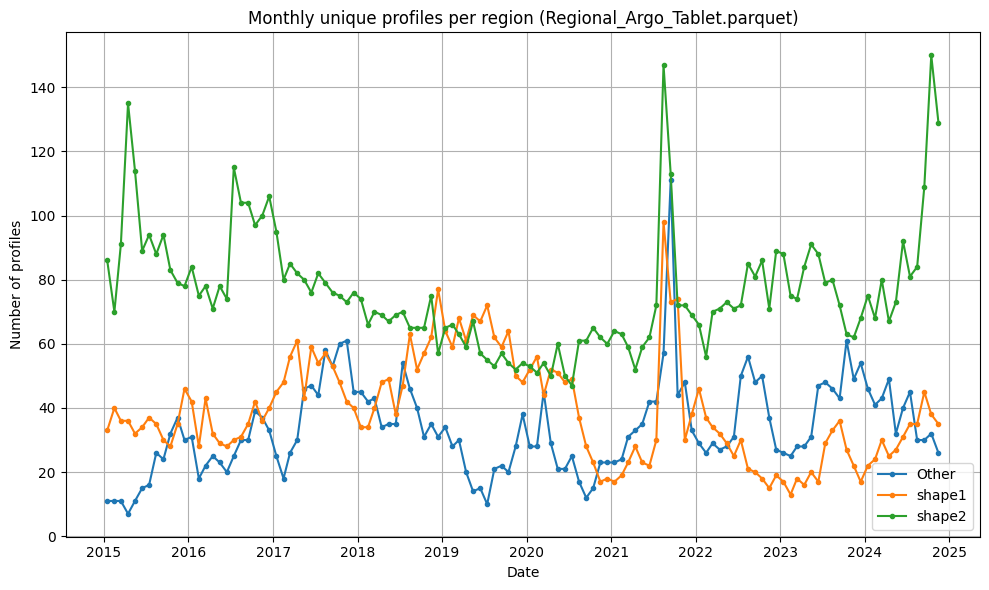

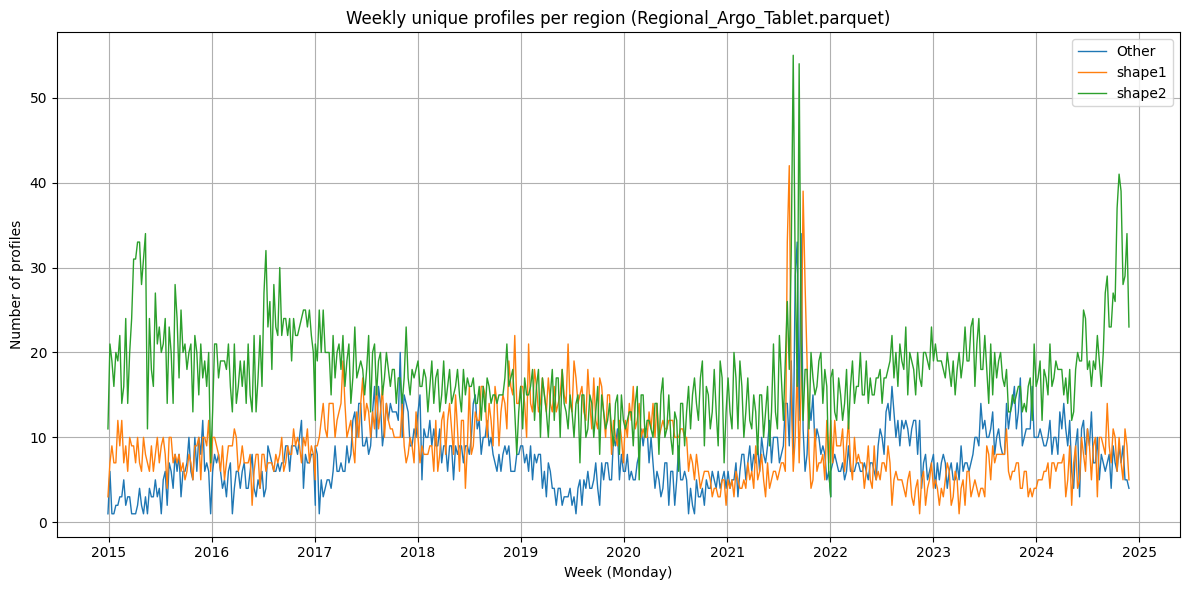


===== Regional_BGC-Argo_Tablet.parquet =====
TIME range: 2015-01-01 08:08:08 → 2024-11-30 22:52:01.002000128


,region,year,month,profile_count
0,Other,2015,1,4
1,Other,2015,2,4
2,Other,2015,3,5
3,Other,2015,4,2
4,Other,2015,5,2
5,Other,2015,6,7
6,Other,2015,7,8
7,Other,2015,8,15
8,Other,2015,9,9
9,Other,2015,10,10


,region,year,week,profile_count
0,Other,2015,2,2
1,Other,2015,3,1
2,Other,2015,5,1
3,Other,2015,6,1
4,Other,2015,8,1
5,Other,2015,9,2
6,Other,2015,10,1
7,Other,2015,11,1
8,Other,2015,12,2
9,Other,2015,13,1


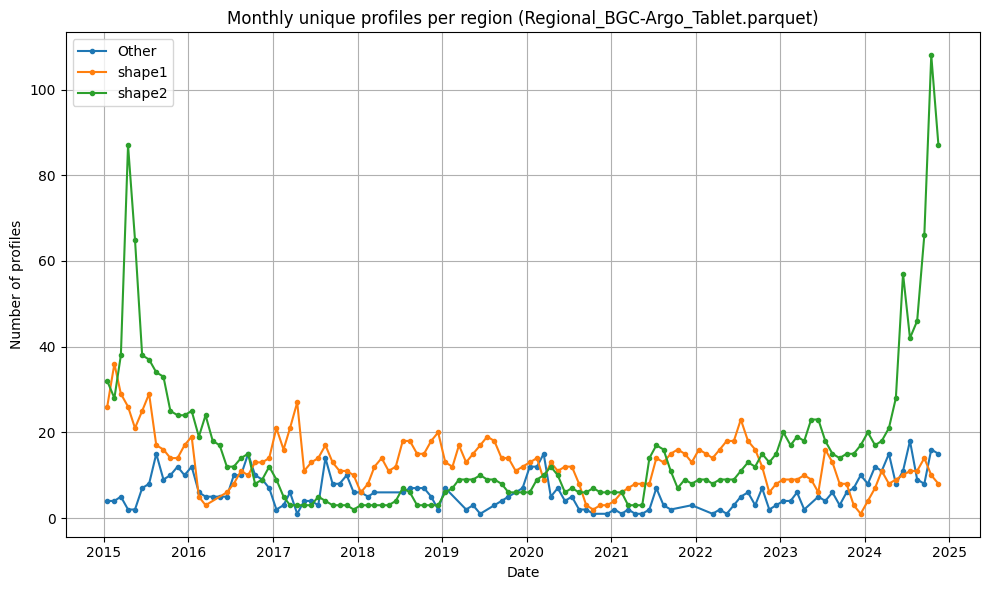

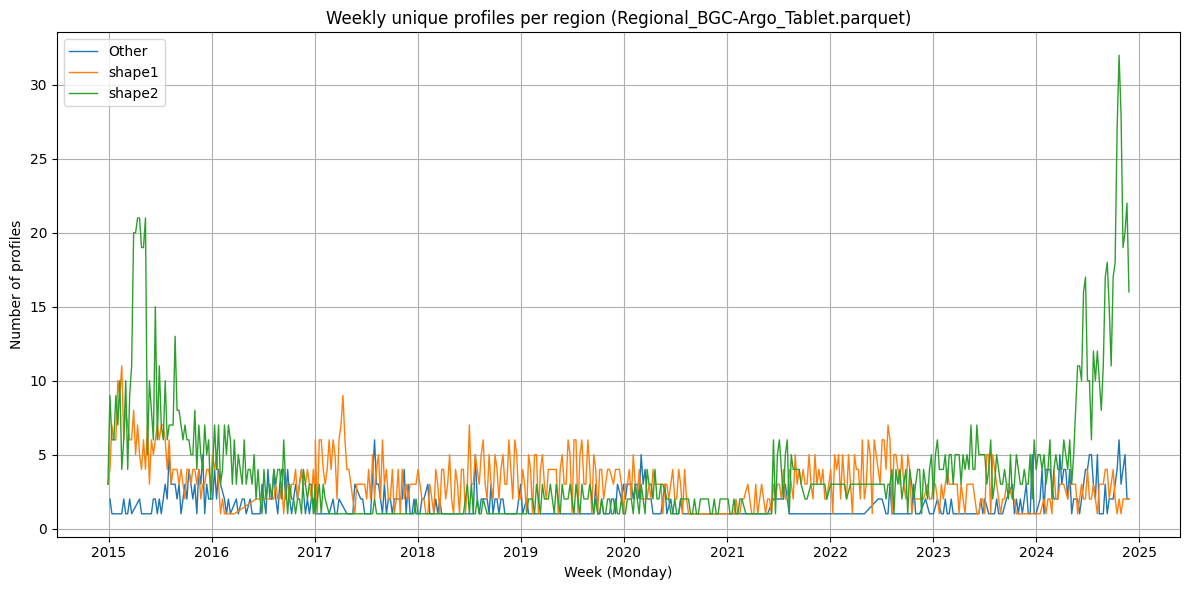

In [17]:
# --- Quick check: number of unique profiles per region for BOTH datasets ---

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Files to analyze
parquets = [
    Path("../data/argo/Region/Regional_Argo_Tablet.parquet"),
    Path("../data/argo/Region/Regional_BGC-Argo_Tablet.parquet"),
]

# Columns (adjust if needed)
COL_TIME = "TIME"
COL_PLATFORM = "PLATFORM_NUMBER"
COL_CYCLE = "CYCLE_NUMBER"
COL_REGION = "region"

for parquet_path in parquets:
    print(f"\n===== {parquet_path.name} =====")
    df = pd.read_parquet(parquet_path)

    # --- Parse datetime ---
    df[COL_TIME] = pd.to_datetime(df[COL_TIME], errors="coerce", utc=True).dt.tz_convert(None)
    print("TIME range:", df[COL_TIME].min(), "→", df[COL_TIME].max())

    # --- Each (platform, cycle, region) = one profile ---
    profiles = df.drop_duplicates(subset=[COL_PLATFORM, COL_CYCLE, COL_REGION]).copy()

    # --- Extract year / month / ISO week ---
    profiles["year"] = profiles[COL_TIME].dt.year
    profiles["month"] = profiles[COL_TIME].dt.month
    profiles["week"] = profiles[COL_TIME].dt.isocalendar().week.astype(int)

    # --- Count profiles per region ---
    monthly_counts = (
        profiles.groupby(["region", "year", "month"], dropna=False)
        .size()
        .reset_index(name="profile_count")
        .sort_values(["region", "year", "month"])
    )

    weekly_counts = (
        profiles.groupby(["region", "year", "week"], dropna=False)
        .size()
        .reset_index(name="profile_count")
        .sort_values(["region", "year", "week"])
    )

    display(monthly_counts.head(10))
    display(weekly_counts.head(10))

    # --- Monthly plot ---
    plt.figure(figsize=(10, 6))
    for region, group in monthly_counts.groupby("region", dropna=False):
        # Plot at mid-month
        dates = pd.to_datetime(group["year"].astype(str) + "-" + group["month"].astype(str) + "-15")
        label = "NaN" if pd.isna(region) else region
        plt.plot(dates, group["profile_count"], marker="o", ms=3, label=label)
    plt.title(f"Monthly unique profiles per region ({parquet_path.name})")
    plt.xlabel("Date")
    plt.ylabel("Number of profiles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Weekly plot ---
    plt.figure(figsize=(12, 6))
    for region, group in weekly_counts.groupby("region", dropna=False):
        # Monday of the ISO week
        dates = pd.to_datetime(
            group["year"].astype(str) + "-W" + group["week"].astype(str) + "-1",
            format="%G-W%V-%u",
        )
        label = "NaN" if pd.isna(region) else region
        plt.plot(dates, group["profile_count"], linewidth=1, label=label)
    plt.title(f"Weekly unique profiles per region ({parquet_path.name})")
    plt.xlabel("Week (Monday)")
    plt.ylabel("Number of profiles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Physical Parameters

MLD Was estiamted using gsw and Adjusted values. MLD time series was also developed, values were averaged weekly (atleast at first) 

#### Producing MLD

In [81]:
# Defining Function

"""
  In site density Calculation Function.
Using Gibbs SeaWater (GSW) Oceanographic Toolbox, it is added as 
another column to the Polars DataFrame.
"""
def add_density(df: pl.DataFrame) -> pl.DataFrame:
    # Extract numpy arrays
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    # Compute absolute salinity, conservative temperature, density
    SA  = gsw.SA_from_SP(SP, p, lon, lat)
    CT  = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)

    # Append new column as a Polars Series
    return df.with_columns(pl.Series("RHO", rho))

# Creating potential density function (for MLD calculations)
def add_sigma0(df: pl.DataFrame) -> pl.DataFrame:
    """
    Add potential density anomaly sigma0 [kg/m^3 - 1000] as a column 'SIGMA0'.
    Requires PSAL [PSS-78], TEMP [°C in-situ], PRES [dbar], LONGITUDE [degE], LATITUDE [degN].
    """
    SP  = df["PSAL_ADJUSTED"].to_numpy()
    t   = df["TEMP_ADJUSTED"].to_numpy()
    p   = df["PRES_ADJUSTED"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)  # kg/m^3 - 1000
    return df.with_columns(pl.Series("SIGMA0", sigma0))

# Creating Mixed Layer Depth function for MLD calculations
"""
 Calculation based on de Montety et al. (2014) definition:
"""
# Compute MLD per profile
def compute_mld_for_profile(pres: np.ndarray, sigma0: np.ndarray,
                            ref_depth: float = 10.0, drho_threshold: float = 0.03) -> float:
    sort_idx = np.argsort(pres)
    pres_sorted = pres[sort_idx]
    sigma0_sorted = sigma0[sort_idx]
    idx_ref = np.argmin(np.abs(pres_sorted - ref_depth))
    sigma0_ref = sigma0_sorted[idx_ref]
    sigma0_th = sigma0_ref + drho_threshold
    mask = sigma0_sorted >= sigma0_th
    mask[:(idx_ref+1)] = False
    if not np.any(mask):
        return np.nan
    idx_mld = np.where(mask)[0][0]
    return float(pres_sorted[idx_mld])





In [ ]:
# Fetching data from Parquet.
df = pl.read_parquet('../data/argo/Region/Regional_Argo_Table.parquet')

# Filtering data below 500m
df = df.filter(pl.col('PRES') < 1000)

# EStimating MLD

# Applying potential density Density calc Function
df = add_sigma0(df)

# Groupin and computing MLD per profile 
summary_mld = (
    df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER")
      .map_groups(lambda group: pl.DataFrame({
            "PLATFORM_NUMBER": [group["PLATFORM_NUMBER"].to_list()[0]],
            "CYCLE_NUMBER": [group["CYCLE_NUMBER"].to_list()[0]],
            "MLD": [
              compute_mld_for_profile(
                pres=group["PRES"].to_numpy(),
                sigma0=group["SIGMA0"].to_numpy(),
                ref_depth=10.0,
                drho_threshold=0.03
              )
            ]
        }))
)

# Joining MLD replicating to dataframe
df = df.join(summary_mld, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()

CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,VERTICAL_SAMPLING_SCHEME,LATITUDE,LONGITUDE,TIME,region,SIGMA0,MLD
i64,i64,str,str,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,i64,str,f64,f64,datetime[ns],str,f64,f64
14,64,"""D""","""A""",6901647,1,5.1,5.1,2.4,1,1,35.082001,35.133999,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00,"""shape2""",27.414977,495.0
14,64,"""D""","""A""",6901647,1,5.7,5.7,2.4,1,1,35.082001,35.133999,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00,"""shape2""",27.414987,495.0
14,64,"""D""","""A""",6901647,1,6.4,6.4,2.4,1,1,35.083,35.134998,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00,"""shape2""",27.415783,495.0
14,64,"""D""","""A""",6901647,1,7.5,7.5,2.4,1,1,35.082001,35.133999,0.01,1,3,7.774,7.774,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00,"""shape2""",27.415163,495.0
14,64,"""D""","""A""",6901647,1,8.5,8.5,2.4,1,1,35.082001,35.133999,0.01,1,3,7.773,7.773,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00,"""shape2""",27.415327,495.0


#### Creating Time MLD time series 
Time series was created by using weekly averages and linear interporlation for each Region

In [ ]:
# Creating MLD time series

# Seperating Regions
shape1 = df.filter(pl.col('region') == 'shape1').to_pandas()
shape2 = df.filter(pl.col('region') == 'shape2').to_pandas()

# Seperating individual profiles so each (platform, cycle) is one profile

shape1 = shape1.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()
shape2 = shape2.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()

# Convert TIME to datetime
shape1["TIME"] = pd.to_datetime(shape1["TIME"])
shape2["TIME"] = pd.to_datetime(shape2["TIME"])

# Creating year-week columns
shape1["year"] = shape1["TIME"].dt.year
shape1["week"] = shape1["TIME"].dt.isocalendar().week
shape2["year"] = shape2["TIME"].dt.year
shape2["week"] = shape2["TIME"].dt.isocalendar().week

# Averaging MLD per week
weekly_mld_shape1 = (
    shape1.groupby(["year", "week"])
    .agg({"MLD": "mean"})
    .reset_index()
)
weekly_mld_shape2 = (
    shape2.groupby(["year", "week"])
    .agg({"MLD": "mean"})
    .reset_index()
)


,year,week,MLD
0,2015,1,452.972726
1,2015,2,506.669998
2,2015,3,531.173684
3,2015,4,512.343753
4,2015,5,526.374992


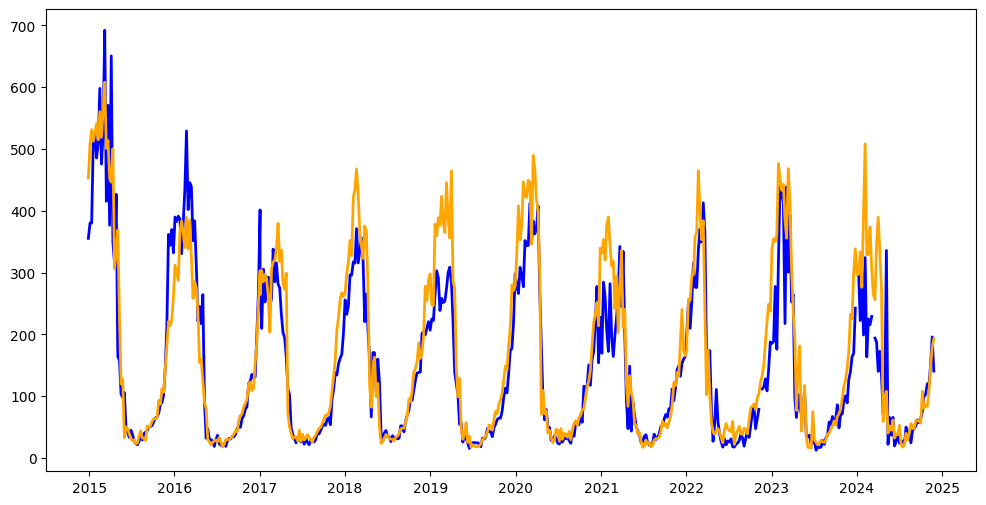

In [113]:
# PLotting MLD time series
plt.figure(figsize=(12,6))
# Shape 1
dates1 = pd.to_datetime(weekly_mld_shape1["year"].astype(str) + "-W" + weekly_mld_shape1["week"].astype(str) + "-1", format="%G-W%V-%u")
plt.plot(dates1, weekly_mld_shape1["MLD"], label="Shape 1", color='blue', linewidth=2)
# Shape 2
dates2 = pd.to_datetime(weekly_mld_shape2["year"].astype(str) + "-W" + weekly_mld_shape2["week"].astype(str) + "-1", format="%G-W%V-%u")
plt.plot(dates2, weekly_mld_shape2["MLD"], label="Shape 2", color='orange', linewidth=2)

In [121]:
import datetime as dt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

# --- Separating Regions ---
shape1 = df.filter(pl.col('region') == 'shape1').to_pandas()
shape2 = df.filter(pl.col('region') == 'shape2').to_pandas()

# --- One row per (platform, cycle) profile ---
shape1 = shape1.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()
shape2 = shape2.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()

# --- TIME to datetime ---
shape1["TIME"] = pd.to_datetime(shape1["TIME"])
shape2["TIME"] = pd.to_datetime(shape2["TIME"])

# --- ISO year/week ---
shape1["year"] = shape1["TIME"].dt.isocalendar().year.astype(int)
shape1["week"] = shape1["TIME"].dt.isocalendar().week.astype(int)
shape2["year"] = shape2["TIME"].dt.isocalendar().year.astype(int)
shape2["week"] = shape2["TIME"].dt.isocalendar().week.astype(int)

# --- Weekly mean + range (min/max) ---
weekly1 = (
    shape1.groupby(["year", "week"])
          .agg(MLD_mean=("MLD", "mean"),
               MLD_min=("MLD", "min"),
               MLD_max=("MLD", "max"))
          .reset_index()
)
weekly2 = (
    shape2.groupby(["year", "week"])
          .agg(MLD_mean=("MLD", "mean"),
               MLD_min=("MLD", "min"),
               MLD_max=("MLD", "max"))
          .reset_index()
)

# --- Convert ISO year-week to a date (Monday of that ISO week) ---
def iso_to_date(df):
    dates = [dt.date.fromisocalendar(int(y), int(w), 1) for y, w in zip(df["year"], df["week"])]
    df = df.assign(date=pd.to_datetime(dates)).sort_values("date")
    return df

weekly1 = iso_to_date(weekly1)
weekly2 = iso_to_date(weekly2)

# Optional: drop rows where stats are all NaN (e.g., empty weeks)
weekly1 = weekly1.dropna(subset=["MLD_mean", "MLD_min", "MLD_max"])
weekly2 = weekly2.dropna(subset=["MLD_mean", "MLD_min", "MLD_max"])


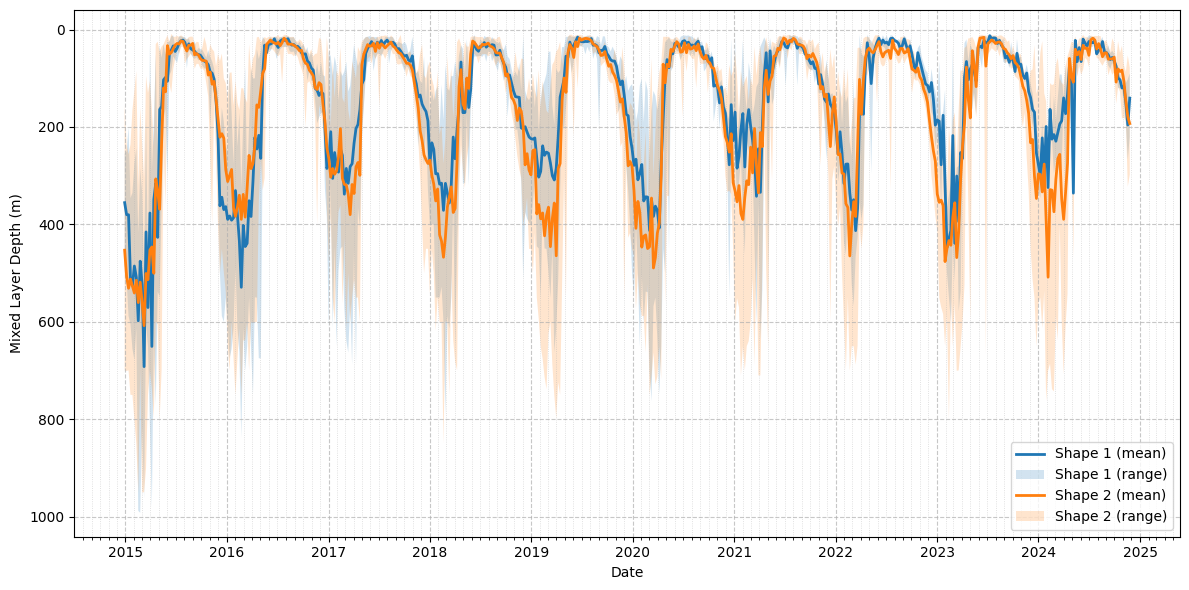

In [120]:
#Plotting 
fig, ax = plt.subplots(figsize=(12, 6))

# Shape 1 Mea
ax.plot(weekly1["date"], weekly1["MLD_mean"], label="Shape 1 (mean)", linewidth=2)
ax.fill_between(
    weekly1["date"],
    weekly1["MLD_min"],
    weekly1["MLD_max"],
    alpha=0.2,
    label="Shape 1 (range)"
)
# Shape 2 
ax.plot(weekly2["date"], weekly2["MLD_mean"], label="Shape 2 (mean)", linewidth=2)
ax.fill_between(
    weekly2["date"],
    weekly2["MLD_min"],
    weekly2["MLD_max"],
    alpha=0.2,
    label="Shape 2 (range)"
)
# Invert y-axis (MLD increases downward)
ax.invert_yaxis()

# Labels
ax.set_xlabel("Date")
ax.set_ylabel("Mixed Layer Depth (m)")

# Ticks: yearly majors, monthly minors
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_minor_locator(MonthLocator())

# Grid
ax.grid(True, which="major", linestyle="--", linewidth=0.8, alpha=0.7)
ax.grid(True, which="minor", linestyle=":", linewidth=0.6, alpha=0.5)

# Legend
ax.legend()

fig.tight_layout()
plt.show()

## BGC-Chlorophyll Analysis
Here we conduct Analysis on BGC-CHLA analysis